## Subtask 2 - Polarization type classification

Multi-label classification to identify the target of polarization as one of the following categories: Gender/Sexual, Political, Religious, Racial/Ethnic, or Other.
For this task we will load the data for subtask 2.

## Imports

In [1]:
import pandas as pd

from sklearn.metrics import recall_score, precision_score, f1_score
import numpy as np

import torch

from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from torch.utils.data import Dataset

In [2]:
import random
import numpy as np
import torch

SEED = 42

# Python
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch (CPU)
torch.manual_seed(SEED)

# PyTorch (GPU)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if you have multiple GPUs

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import wandb

# Disable wandb logging for this script
wandb.init(mode="disabled")

## Data Import

The training data consists of a short text and binary labels

The data is structured as a CSV file with the following fields:
- id: a unique identifier for the sample
- text: a sentence or short text
- polarization:  1 text is polarized, 0 text is not polarized

The data is in all three subtask folders the same but only containing the labels for the specific task.

In [4]:
# Load the training and validation data for subtask 1

train = pd.read_csv('subtask2/train/swa.csv')
# train_plus = pd.read_csv('english_data.csv')
train_plus = pd.read_csv('eng_BT_full.csv')

train.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other
0,swa_53de6a7a4d0123b5755da79d8d97a82f,uwizi rt kenyan rao akishinda nitachinja kuku ...,0,1,0,0,0
1,swa_ee2533cb334df97236ea2bcfda0d6823,wakikuyu ndio wako na manyumba za kukodeshwa t...,0,1,0,0,0
2,swa_1dd81b5985840a55b1ab292aa65d11a8,wakikuyu ni wezi power hungry and this time we...,0,1,0,0,0
3,swa_18589adc3945e20c5e5c61e10245fad1,wakikuyu sijui shida yenu ni nini kuogopa rail...,0,1,0,0,0
4,swa_aee76fc4cd1c6c6c09e19ba5ddd3901a,wakikuyu walisogwa hwakuumbwa,0,1,0,0,0


In [5]:
train_plus.head()

,id,text,political,racial/ethnic,religious,gender/sexual,other,back_translated
0,eng_973938b90b0ff5d87d35a582f83f5c89,is defending imperialism in the dnd chat,0,0,0,0,0,defends imperialism in the dnd cat
1,eng_07dfd4600426caca6e2c5883fcbea9ea,Still playing with this. I am now following Ra...,0,0,0,0,0,I'm Rachel Maddie from msnbc.
2,eng_f14519ff2302b6cd47712073f13bc461,.senate.gov Theres 3 groups out there Republic...,0,0,0,0,0,".senate.gov Theres 3 groups there Republicans,..."
3,eng_e48b7e7542faafa544ac57b64bc80daf,"""ABC MD, David Anderson, said the additional f...",0,0,0,0,0,"""Continuing investment in ABC is essential to ..."
4,eng_7c581fb77bce8033aeba3d6dbd6273eb,"""bad people"" I have some conservative values s...",0,0,0,0,0,I have conservative values and that makes me o...


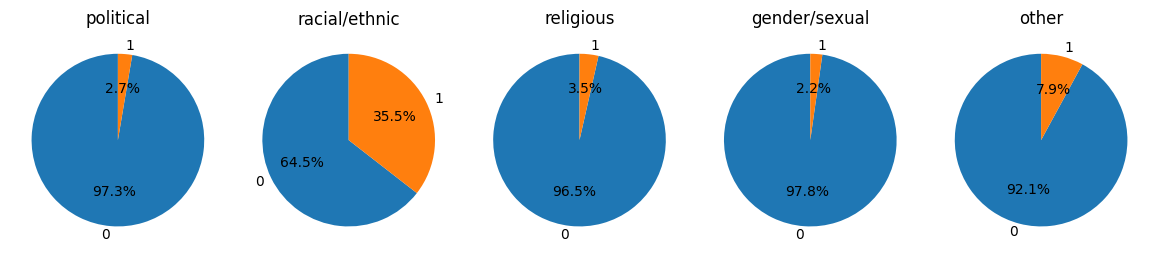

In [6]:
import matplotlib.pyplot as plt

labels = train.columns[2:]
n = len(labels)

# A4 landscape size (inches)
fig, axes = plt.subplots(1, n, figsize=(11.69, 2.8))

# If only one label, axes is not iterable
if n == 1:
    axes = [axes]

for idx, label in enumerate(labels):
    counts = train[label].value_counts().sort_index()
    
    axes[idx].pie(
        counts,
        labels=["0", "1"],
        autopct="%1.1f%%",
        startangle=90
    )
    axes[idx].set_title(label)

plt.tight_layout()
plt.savefig("repartition.pdf")
plt.show()

# Dataset
-  Create a pytorch class for handling data
-  Wrapping the raw texts and labels into a format that Huggingface’s Trainer can use for training and evaluation

In [7]:
# Fix the dataset class by inheriting from torch.utils.data.Dataset
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self,texts,labels,tokenizer,max_length =128):
    self.texts=texts
    self.labels=labels
    self.tokenizer= tokenizer
    self.max_length = max_length # Store max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False, max_length=self.max_length, return_tensors='pt')

        # Ensure consistent tensor conversion for all items
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        # CHANGE THIS LINE: Use torch.float instead of torch.long for multi-label classification
        item['labels'] = torch.tensor(label, dtype=torch.float)
        return item

Now, we'll tokenize the text data and create the datasets using `bert-base-uncased` as the tokenizer.

## Base-line from here

In [8]:
# Load the tokenizer
MODEL_NAME = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

## Data processing

In [9]:
# Add the labels to the translated
train_plus = train_plus.drop(columns=["text"])
train_plus['text'] = train_plus['back_translated']
# train_plus[['political','racial/ethnic','religious','gender/sexual','other']] = train[['political','racial/ethnic','religious','gender/sexual','other']].values
# train_plus = pd.concat([train_plus, train[['political','racial/ethnic','religious','gender/sexual','other']]], axis=1)

# Sample some from the translation
sample_size = 1000
back_tranlated_sampled = train_plus.sample(n=1000)

# train_combined = pd.concat([train, back_tranlated_sampled], axis=0)
val_df = back_tranlated_sampled.sample(n=300, random_state=42)

In [10]:
# Create train and Test dataset for multilabel
train_dataset = PolarizationDataset(
    train['text'].tolist(),
    train[['political','racial/ethnic','religious','gender/sexual','other']].values.tolist(),
    tokenizer
)
val = PolarizationDataset(
    val_df['text'].tolist(),
    val_df[['political','racial/ethnic','religious','gender/sexual','other']].values.tolist(),
    tokenizer
)

In [11]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=5,
    problem_type="multi_label_classification",
    local_files_only=True
)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining training arugments

In [12]:
model.to('cuda')

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=f"./",
    num_train_epochs=3,
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    disable_tqdm=False
)

# Define metrics function for multi-label classification
def compute_metrics_multilabel(p):
    probs = torch.sigmoid(torch.from_numpy(p.predictions))

    thresholds = torch.tensor([0.3, 0.25, 0.05, 0.05, 0.05])

    preds = (probs > thresholds).int()

    return {
        "f1_macro": f1_score(
            p.label_ids,
            preds.numpy(),
            average="macro"
        )
    }


In [14]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val,
    compute_metrics=compute_metrics_multilabel,
    data_collator=DataCollatorWithPadding(tokenizer)
)

# Train the model
trainer.train()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Macro F1 score on validation set for Subtask 3: {eval_results['eval_f1_macro']}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 734.00 MiB. GPU 0 has a total capacity of 3.94 GiB of which 614.75 MiB is free. Including non-PyTorch memory, this process has 3.05 GiB memory in use. Of the allocated memory 2.81 GiB is allocated by PyTorch, and 179.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
# Load the dev data (only has 'id' and 'text' columns)
dev = pd.read_csv('subtask2/dev/swa.csv')

# Create a dataset for dev (without labels)
class PolarizationDatasetTest(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding=False,
                                   max_length=self.max_length, return_tensors='pt')
        item = {key: encoding[key].squeeze() for key in encoding.keys()}
        return item


# Build test dataset
test_dataset = PolarizationDatasetTest(dev['text'].tolist(), tokenizer)

# Run prediction
pred_output = trainer.predict(test_dataset)

# Get logits → probabilities
probs = torch.sigmoid(
    torch.from_numpy(pred_output.predictions)
).numpy()

# Per-label thresholds (must match number of labels)
thresholds = np.array([0.005, 0.3, 0.4, 0.005, 0.005])

# Apply thresholds (vectorized)
preds = (probs > thresholds).astype(int)

# Create submission dataframe
submission = pd.DataFrame({
    'id': dev['id'],
    'political': preds[:, 0],
    'racial/ethnic': preds[:, 1],
    'religious': preds[:, 2],
    'gender/sexual': preds[:, 3],
    'other': preds[:, 4]
})

# Save to CSV
submission.to_csv('pred_swa.csv', index=False)

print("Predictions saved to pred_swa.csv")
print(submission.head())

Predictions saved to pred_swa.csv
                                     id  political  racial/ethnic  religious  \
0  swa_a5748df181277341143f7da4175add4a          1              1          0   
1  swa_2df0d42f9b49ea2e4fb006b2e6604e6d          1              1          0   
2  swa_3718757514005767302b7220b08e409d          1              1          0   
3  swa_9fa3337a35cce723d60c06056d422330          1              1          0   
4  swa_5c39ac8ef70345e9e3c21a47f8769bc0          1              1          0   

   gender/sexual  other  
0              1      1  
1              1      1  
2              1      1  
3              1      1  
4              1      1  


In [24]:
# After training
del model
torch.cuda.empty_cache()
import gc
gc.collect()

2074

In [27]:
pred_output

PredictionOutput(predictions=array([[-4.0065017,  2.7779639, -4.369648 , -3.5427132, -2.6700766],
       [-3.7509487,  3.3904135, -3.8340368, -3.3904362, -2.7905686],
       [-3.6664076,  3.5203903, -3.6501486, -3.34996  , -2.7565243],
       ...,
       [-3.3157163, -2.387073 , -3.9302554, -3.6524293, -2.215725 ],
       [-3.4341373, -2.9071746, -3.5758097, -3.8182194, -2.4833395],
       [-3.974063 , -0.6601113, -4.9267473, -3.8578296, -2.360355 ]],
      shape=(349, 5), dtype=float32), label_ids=None, metrics={'test_runtime': 1.7866, 'test_samples_per_second': 195.347, 'test_steps_per_second': 24.628})